### AdaDelta

Point:RMSpropにもう一段改良を加えたもの。学習パラメータが未探索領域に入ったときに，探索距離を広げる。

$$
\begin{align}
    \boldsymbol{h}^t &\leftarrow \gamma\boldsymbol{h}^{t-1} + (1-\gamma) \frac{\partial L}{\partial \boldsymbol{w}}^t\odot\frac{\partial L}{\partial \boldsymbol{w}}^t\\
    \boldsymbol{s}^t &\leftarrow \gamma\boldsymbol{s}^{t-1} + (1-\gamma) (\Delta\boldsymbol{w}^t)^2\\
    \Delta\boldsymbol{w}^t &= \frac{\sqrt{\boldsymbol{s}^{t-1} + \epsilon}}{\sqrt{\boldsymbol{h}^t + \epsilon}}\frac{\partial L}{\partial \boldsymbol{w}}^t\\
    \boldsymbol{w}^{t+1} &\leftarrow \boldsymbol{w}^t - \Delta\boldsymbol{w}^t
\end{align}
$$

初期値$\boldsymbol{h}$=0, $\boldsymbol{s}$=0. $\boldsymbol{w}$が大きく更新された場合，未探索の領域に突入して，$\boldsymbol{s}$の値が大きくなり，$\Delta\boldsymbol{w}$の値が大きくなる

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class AdaDelta:
    def __init__(self, f, df, alpha=0.01, gamma=0.99, eps=1e-6):
        self.f_= f
        self.df_= df
        self.alpha_= alpha
        self.gamma_ = gamma
        self.eps_= eps
        self.path_= None
        
    def solve(self, init):
        x = init
        h = np.zeros_like(x)
        s = np.zeros_like(x)
        delta_x = np.zeros_like(x)
        path = []
        path.append(x)
        grad = self.df_(x)
        
        while (grad**2).sum() > self.eps_**2:
            grad = self.df_(x)
            h = self.gamma_ * h + (1 - self.gamma_) * grad * grad # 荷重減衰項
            delta_x = -np.sqrt((s + self.eps_) / (h + self.eps_)) * grad
            s = self.gamma_ * s + (1 - self.gamma_) * delta_x * delta_x # 未探索領域促進項
            x = x + delta_x
            path.append(x)
            
        self.path_ = np.array(path)
        self.x_ = x
        self.opt_ = self.f_(x)

勾配降下法

In [4]:
class GradientDescent:
    def __init__(self, f, df, alpha=0.01, eps=1e-6):
        self.f_= f
        self.df_= df
        self.alpha_= alpha
        self.eps_= eps
        self.path_= None
        
    def solve(self, init):
        x = init
        path = []
        path.append(x)
        grad = self.df_(x)
        
        while (grad**2).sum() > self.eps_**2:
            grad = self.df_(x)
            x = x - self.alpha_ * grad
            path.append(x)
            
        self.path_ = np.array(path)
        self.x_ = x
        self.opt_ = self.f_(x)

In [5]:
# 目的関数
def f(xx):
    x = xx[0]
    y = xx[1]
    return 5 * x ** 2 - 6 * x * y + 3 * y ** 2 + 6 * x - 6 * y

# 目的関数の微分
def df(xx):
    x = xx[0]
    y = xx[1]
    return np.array([10 * x - 6 * y + 6, -6 * x + 6 * y - 6])

In [6]:
algo = GradientDescent(f, df)
initial = np.array([0.5, 3.2])
algo.solve(initial)
print(algo.x_)
print(algo.opt_)

[3.38025110e-07 1.00000047e+00]
-2.99999999999972


### AdaDelta Test

[2.71547662e-07 1.00000042e+00]
-2.9999999999997855


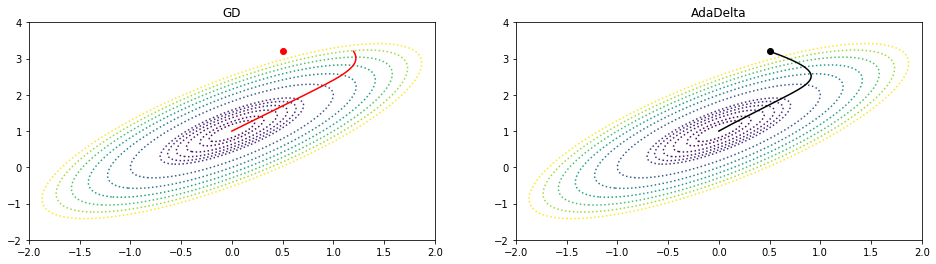

In [9]:

fig, ax = plt.subplots(1,2, figsize=(16,4))

# 左図 init (1.2, 3.2) SGD
ax[0].scatter(initial[0], initial[1], color="r", marker="o")
ax[0].plot(algo.path_[:, 0], algo.path_[:, 1], color="r", linewidth=1.5)

xs = np.linspace(-2, 2, 300)
ys = np.linspace(-2, 4, 400)
xmesh, ymesh = np.meshgrid(xs, ys)
xx = np.r_[xmesh.reshape(1, -1), ymesh.reshape(1, -1)]
levels = [-3, -2.9, -2.8, -2.6, -2.4, -2.2, -2, -1, 0, 1, 2, 3, 4]
ax[0].contour(xs, ys, f(xx).reshape(xmesh.shape), levels=levels, linestyles="dotted")

ax[0].set_ylim([-2, 4])
ax[0].set_xlim([-2, 2])
ax[0].set_title('GD')

# 右図 init (1.2, 3.2) Momentum
Nalgo = AdaDelta(f, df)
initial = np.array([0.5, 3.2])
Nalgo.solve(initial)
print(Nalgo.x_)
print(Nalgo.opt_)

ax[1].scatter(initial[0], initial[1], color="k", marker="o")
ax[1].plot(Nalgo.path_[:, 0], Nalgo.path_[:, 1], color="k", linewidth=1.5)
ax[1].contour(xs, ys, f(xx).reshape(xmesh.shape), levels=levels, linestyles="dotted")

ax[1].set_ylim([-2, 4])
ax[1].set_xlim([-2, 2])
ax[1].set_title('AdaDelta')

plt.show()